In [1]:
#Predict whether a customer will churn based on account information, service usage, and demographics.

In [2]:
###Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shap
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from catboost import CatBoostClassifier

random.seed(1)

print("All core libraries loaded successfully!")

All core libraries loaded successfully!


In [3]:
####Get the data set
filename = "../data/WA_Fn-UseC_-Telco-Customer-Churn.xls"
data = pd.read_csv(filename)
print("File read successfully")

File read successfully


In [4]:
####Uncomment and run to preview first 5 data entries
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
####Clean the data
#Going to go by each column and check unique. Additionally, if the results are not numeric, need to convert
#Removing "customerID", since it is not useful in this context
data = data.drop(['customerID'], axis=1)
#gender
gender_unique = data["gender"].unique()
print(gender_unique)
data["gender"] = data["gender"].map({'Male': 0, 'Female': 1})

#senior
senior_unique = data["SeniorCitizen"].unique()
print(senior_unique)

#partner
partner_unique = data["Partner"].unique()
print(partner_unique)
data["Partner"] = data["Partner"].map({'Yes': 1, 'No': 0})

#dependents
dependents_unique = data["Dependents"].unique()
print(dependents_unique)
data["Dependents"] = data["Dependents"].map({'Yes': 1, 'No': 0})

#tenure should be a number, just checking to make sure all are logical values
tenure_unique = data["tenure"].unique()
print(tenure_unique)

#PhoneService
service_unique = data["PhoneService"].unique()
print(service_unique)
data["PhoneService"] = data["PhoneService"].map({'Yes': 1, 'No': 0})

#MultipleLines
multiple_unique = data["MultipleLines"].unique()
print(multiple_unique)
data["MultipleLines"] = data["MultipleLines"].map({'Yes': 1, 'No': 0, 'No phone service': 0})

#InternetService
internet_unique = data["InternetService"].unique()
print(internet_unique)
#Fixing together with PaymentMethod later on

#OnlineSecurity
online_unique = data["OnlineSecurity"].unique()
print(online_unique)
data["OnlineSecurity"] = data["OnlineSecurity"].map({'Yes': 1, 'No': 0, 'No internet service': 0})

#OnlineBackup
backup_unique = data["OnlineBackup"].unique()
print(backup_unique)
data["OnlineBackup"] = data["OnlineBackup"].map({'Yes': 1, 'No': 0, 'No internet service': 0})

#DeviceProtection
device_unique = data["DeviceProtection"].unique()
print(device_unique)
data["DeviceProtection"] = data["DeviceProtection"].map({'Yes': 1, 'No': 0, 'No internet service': 0})

#TechSupport
tech_unique = data["TechSupport"].unique()
print(tech_unique)
data["TechSupport"] = data["TechSupport"].map({'Yes': 1, 'No': 0, 'No internet service': 0})

#StreamingTV
streaming_unique = data["StreamingTV"].unique()
print(streaming_unique)
data["StreamingTV"] = data["StreamingTV"].map({'Yes': 1, 'No': 0, 'No internet service': 0})

#StreamingMovies
movies_unique = data["StreamingMovies"].unique()
print(movies_unique)
data["StreamingMovies"] = data["StreamingMovies"].map({'Yes': 1, 'No': 0, 'No internet service': 0})

#Contract
contract_unique = data["Contract"].unique()
print(contract_unique)
data["Contract"] = data["Contract"].map({'Month-to-month': 1, 'One year': 2, 'Two year': 3})

#PaperlessBilling
paperless_unique = data["PaperlessBilling"].unique()
print(paperless_unique)
data["PaperlessBilling"] = data["PaperlessBilling"].map({'Yes': 1, 'No': 0})

#PaymentMethod
payment_unique = data["PaymentMethod"].unique()
print(payment_unique)
data = pd.get_dummies(data, columns=["PaymentMethod", "InternetService"], drop_first=True)

#MonthlyCharges
mcharges_unique = data["MonthlyCharges"].unique()
print(mcharges_unique)

#TotalCharges
#Fixing type
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="coerce")
tcharges_unique = data["TotalCharges"].unique()
print(tcharges_unique)

#Churn
churn_unique = data["Churn"].unique()
print(churn_unique)
data["Churn"] = data["Churn"].map({'Yes': 1, 'No': 0})

['Female' 'Male']
[0 1]
['Yes' 'No']
['No' 'Yes']
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
['No' 'Yes']
['No phone service' 'No' 'Yes']
['DSL' 'Fiber optic' 'No']
['No' 'Yes' 'No internet service']
['Yes' 'No' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['No' 'Yes' 'No internet service']
['Month-to-month' 'One year' 'Two year']
['Yes' 'No']
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
[29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
[  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
['No' 'Yes']


In [6]:
###Organizing the data into X and Y components, along with splitting into training, validation, and testing sets.
#Check for NaN and NULL data points. Uncomment the line below to see number of empty data slots in each column.
#print(data.isnull().sum())
#print((data == '').sum())

#11 nulls exist in TotalCharges. Given that the dataset is over 7000 entries, just dropping them.
data = data[data['TotalCharges'].notna()]

#Remove "Churn" to get x variable.
X_total = data.drop(['Churn'], axis=1)

#y variable will be "Churn".
Y_total = data["Churn"]

#Seperating X and Y value into final train,valid,test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X_total, Y_total, test_size=0.3, random_state=1, stratify=Y_total)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=1, stratify=Y_temp)

In [7]:
###Hyperparameter Tuning to find optimal model configuration
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

#grid = GridSearchCV(XGBClassifier(), param_grid, cv=3, scoring='accuracy')
#grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='accuracy')
grid = GridSearchCV(CatBoostClassifier(), param_grid, cv=3, scoring='accuracy')

grid.fit(X_train, Y_train, verbose=False)

print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best score: 0.8013011350406009


In [8]:
###Training model on 70%, validation on 15%, testing on 15%. Then creating predictions on the test cases.
###CatBoostClassifer was found to be the best model of the three listed.
scale_pos_weight = sum(Y_train == 0) / sum(Y_train == 1)
#my_model = XGBClassifier(n_estimators=200, learning_rate=0.01, n_jobs=4,early_stopping_rounds=20,max_depth=5,scale_pos_weight=scale_pos_weight,eval_metric='logloss')
#my_model = RandomForestClassifier(max_depth=5,n_estimators=200)

my_model = CatBoostClassifier(learning_rate=0.1,max_depth=3,n_estimators=100)

my_model.fit(X_train,Y_train,eval_set=[(X_valid,Y_valid)],verbose=False)
y_probs = my_model.predict_proba(X_test)[:, 1] 
prediction = (y_probs >= 0.45).astype(int)

In [9]:
###Threshold Tuning
y_probs = my_model.predict_proba(X_test)[:, 1] 
thresholds = np.arange(0.1, 0.9, 0.05)

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    print(f"--- Threshold: {threshold:.2f} ---")
    print(classification_report(Y_test, y_pred, digits=3))
    print(f"ROC-AUC: {roc_auc_score(Y_test, y_probs):.4f}\n")

--- Threshold: 0.10 ---
              precision    recall  f1-score   support

           0      0.962     0.453     0.616       774
           1      0.387     0.950     0.550       281

    accuracy                          0.586      1055
   macro avg      0.674     0.702     0.583      1055
weighted avg      0.809     0.586     0.599      1055

ROC-AUC: 0.8457

--- Threshold: 0.15 ---
              precision    recall  f1-score   support

           0      0.943     0.537     0.685       774
           1      0.417     0.911     0.572       281

    accuracy                          0.637      1055
   macro avg      0.680     0.724     0.628      1055
weighted avg      0.803     0.637     0.655      1055

ROC-AUC: 0.8457

--- Threshold: 0.20 ---
              precision    recall  f1-score   support

           0      0.935     0.630     0.753       774
           1      0.463     0.879     0.607       281

    accuracy                          0.697      1055
   macro avg      0.69

Accuracy:  80.85308056872039 %
Dummy Classifier Accuracy: 0.7336492890995261
Logistic Regression Accuracy: 0.804739336492891
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       774
           1       0.65      0.61      0.63       281

    accuracy                           0.81      1055
   macro avg       0.76      0.75      0.75      1055
weighted avg       0.81      0.81      0.81      1055

ROC-AUC: 0.8456532134219795


C:\Users\Xander\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


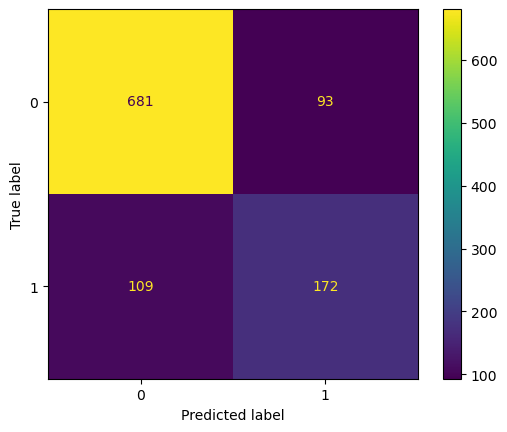

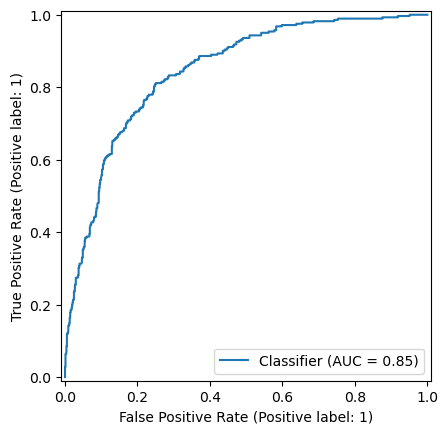

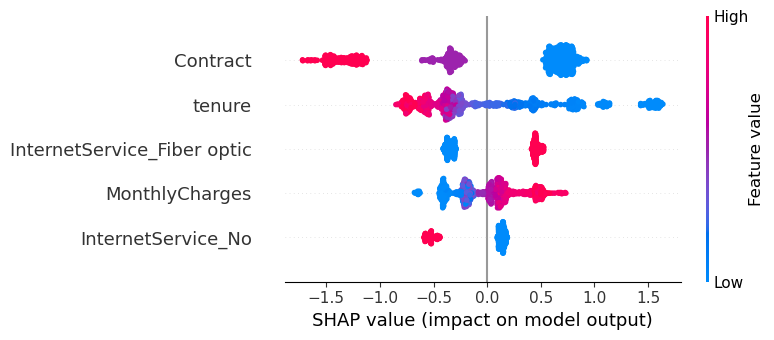

<Figure size 640x480 with 0 Axes>

In [10]:
###Assessing the model
#Calculate and output accuracy
print("Accuracy: ",accuracy_score(Y_test,prediction)*100,"%")

#Compare accuracy to baseline predictions
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, Y_train)
print("Dummy Classifier Accuracy:", dummy.score(X_test, Y_test))

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, Y_train)
print("Logistic Regression Accuracy:", logreg.score(X_test, Y_test))

#Classification Report
print(classification_report(Y_test, prediction))

#Confusion Matrix
cm = confusion_matrix(Y_test,prediction)
ConfusionMatrixDisplay(cm).plot()

#AUC-ROC Curve
y_proba = my_model.predict_proba(X_test)[:, 1]
print("ROC-AUC:", roc_auc_score(Y_test, y_proba))
RocCurveDisplay.from_predictions(Y_test, y_proba)

#SHAP Analysis (in-depth feature analysis)
explainer = shap.Explainer(my_model)
shap_values = explainer(X_test)
plt.figure(figsize=(8, 5)) 
shap.summary_plot(shap_values, X_test, max_display=5)
plt.tight_layout()